In [1]:
import pandas as pd
import numpy as np
from scripts import *
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
# importing main data
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
missing_vals = pd.read_csv('bedroomsfilled.csv')
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')

# import additional zipcode data
zipcode_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
clean_data(training_data)
clean_data(missing_vals)
training_data = no_bedrooms(training_data, missing_vals)
training_data


#replace 33 bedrooms with correct value
training_data.set_value(8597, 'bedrooms', 3)

(17290, 23)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,10
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,8
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,8
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,3
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2954400190,2014-06-24,1295650.0,4,4.50,4810,28008,2.0,0,0,...,0,1990,0,98053,47.6642,-122.069,4740,35061,2014,6
8,3980300371,2014-09-26,142000.0,1,0.75,290,20875,1.0,0,0,...,0,1954,0,98024,47.5308,-121.888,1620,22850,2014,9
9,2310060040,2014-09-25,240000.0,4,2.50,1810,5669,2.0,0,0,...,0,2003,0,98038,47.3493,-122.053,1810,5685,2014,9
10,6896300380,2014-10-02,228000.0,2,1.00,390,5900,1.0,0,0,...,0,1953,0,98118,47.5260,-122.261,2170,6000,2014,10


In [3]:
zipcode_data.set_index('zipcode', inplace=True)

In [4]:
training_data = pd.merge(training_data, zipcode_data, how='right', on='zipcode')
training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

In [5]:
training_data.drop(columns='date', inplace=True)

# Log Transform SqFt

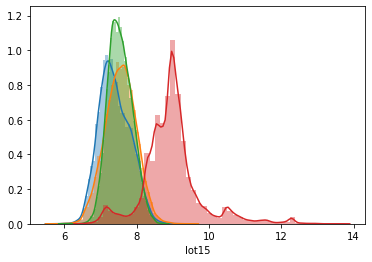

In [6]:
data_log = pd.DataFrame([])
data_log['above'] = np.log(training_data['sqft_above'])
data_log['living15'] = np.log(training_data['sqft_living15'])
data_log['lot15'] = np.log(training_data['sqft_lot15'])
data_log['living'] = np.log(training_data['sqft_living'])
sns.distplot(data_log['above']);
sns.distplot(data_log['living']);
sns.distplot(data_log['living15']);
sns.distplot(data_log['lot15']);

# Min/Max

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_feat = ['pop_density',
               'sqft_living15', 
               'sqft_above', 
               'sqft_basement',
               'bedrooms',
               'bathrooms',
               'median_household_income',
               'median_home_value',
               'sqft_lot']


training_data[scaled_feat] = scaler.fit_transform(training_data[scaled_feat])  

# Dummies

In [8]:

# dummy_cat = ['sale_month','waterfront', 'view', 'condition', 'grade', 'sale_month', 'postoffice', 'zipcode']

# one_hot = pd.get_dummies(training_data, columns = dummy_cat, drop_first=True)

In [9]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)


training_data = training_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)
training_data

# training_data = pd.concat([training_data, one_hot], axis=1)
# training_data.columns = training_data.columns.str.replace('\t', '')
# training_data.columns.to_list()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,365000.0,0.09375,0.28125,2070,0.005041,2.0,0.195175,0.000000,1986,0,...,0,0,0,0,0,0,0,0,0,0
1,455000.0,0.09375,0.21875,2050,0.056914,1.0,0.105263,0.165975,1959,0,...,0,0,0,0,0,0,0,0,0,0
2,273000.0,0.06250,0.21875,2050,0.005133,2.0,0.192982,0.000000,1959,0,...,0,0,0,0,0,0,0,0,0,0
3,223000.0,0.03125,0.12500,910,0.005632,1.0,0.067982,0.000000,1957,0,...,0,0,0,0,0,0,0,0,0,0
4,335500.0,0.12500,0.37500,2240,0.011218,1.0,0.154605,0.112033,1968,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,0.09375,0.46875,4150,0.010208,1.0,0.311404,0.211618,1963,2000,...,0,0,0,0,0,0,0,0,0,0
17286,2450000.0,0.18750,0.53125,4670,0.013656,2.0,0.480263,0.000000,1992,0,...,0,0,0,0,0,0,0,0,0,0
17287,2100000.0,0.09375,0.21875,3550,0.011687,2.0,0.357456,0.000000,1962,2002,...,0,0,0,0,0,0,0,0,0,0
17288,1620000.0,0.09375,0.28125,2350,0.010381,2.0,0.225877,0.000000,1977,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
training_data[['pop_density','sqft_living15', 'sqft_above', 'sqft_basement', 'sqft_lot']] = scaler.fit_transform(training_data[['pop_density','sqft_living15', 'sqft_above', 'sqft_basement', 'sqft_lot']])  

In [11]:
training_data.columns.to_list()

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sale_year',
 'population',
 'pop_density',
 'occupied_housing_units',
 'median_household_income',
 'median_home_value',
 'total_housing_units',
 'land_area',
 'water_area_sq_mile',
 'owned_household_with_mortgage',
 'renter_occupied_households',
 'houses_owned_outright',
 'sold_and_unoccupied',
 'seasonal_or_rec_use',
 'available_housing',
 'waterf_1',
 'has_view_1',
 'has_view_2',
 'has_view_3',
 'has_view_4',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'zip_98002',
 'zip_98003',
 'zip_98004',
 'zip_98005',
 '

In [12]:
training_data.shape

(17290, 129)

In [13]:
training_data.drop(['zip_98003','owned_household_with_mortgage', 'houses_owned_outright','land_area','occupied_housing_units', 'total_housing_units','sqft_living', 'condition_3'], axis=1, inplace=True)

In [14]:
multicolinear_features(training_data)

,cc
pairs,


In [15]:
training_data

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,365000.0,0.09375,0.28125,0.005041,2.0,0.195175,0.000000,1986,0,47.4388,...,0,0,0,0,0,0,0,0,0,0
1,455000.0,0.09375,0.21875,0.056914,1.0,0.105263,0.165975,1959,0,47.4492,...,0,0,0,0,0,0,0,0,0,0
2,273000.0,0.06250,0.21875,0.005133,2.0,0.192982,0.000000,1959,0,47.4572,...,0,0,0,0,0,0,0,0,0,0
3,223000.0,0.03125,0.12500,0.005632,1.0,0.067982,0.000000,1957,0,47.4572,...,0,0,0,0,0,0,0,0,0,0
4,335500.0,0.12500,0.37500,0.011218,1.0,0.154605,0.112033,1968,0,47.4416,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1950000.0,0.09375,0.46875,0.010208,1.0,0.311404,0.211618,1963,2000,47.6390,...,0,0,0,0,0,0,0,0,0,0
17286,2450000.0,0.18750,0.53125,0.013656,2.0,0.480263,0.000000,1992,0,47.6183,...,0,0,0,0,0,0,0,0,0,0
17287,2100000.0,0.09375,0.21875,0.011687,2.0,0.357456,0.000000,1962,2002,47.6236,...,0,0,0,0,0,0,0,0,0,0
17288,1620000.0,0.09375,0.28125,0.010381,2.0,0.225877,0.000000,1977,0,47.6232,...,0,0,0,0,0,0,0,0,0,0


# Sklearn 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

y = training_data.price
x = training_data.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 120), (3458, 120))

In [17]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

RMSE 139726.11516


In [18]:
np.mean(cross_val_score(estimator=lr, X=x_train, y=y_train, cv=10))

-62.22928957033353

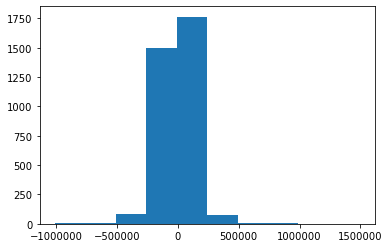

In [19]:
residuals = (y_test - y_hat)
plt.hist(residuals);

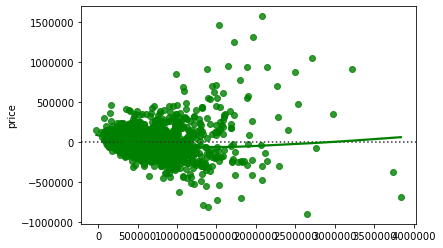

In [20]:
sns.residplot(y_hat, y_test, lowess=True, color='g')

# OLS

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'price'
predictors = training_data.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum


model = ols(formula= formula, data=training_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     790.8
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:08:25   Log-Likelihood:            -2.3065e+05
No. Observations:               17290   AIC:                         4.615e+05
Df Residuals:                   17177   BIC:                         4.624e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.335e+08   1.43e+07     -9.352      0.000   -1.62e+08   -1.06e+08
bedrooms                    -3.81e+05   5.19e+04     -7.340      0.000   -4.83e+05   -2.79e+05
bathrooms                   1.896e+05   2.23e+04      8.515      0.000    1.46e+05    2.33e+05
sqft_lot                    3.413e+05   6.39e+04      5.344      0.000    2.16e+05    4.67e+05
floors                     -2.929e+04   3358.700     -8.720      0.000   -3.59e+04   -2.27e+04
sqft_above                  1.531e+06   3.02e+04     50.681      0.000    1.47e+06    1.59e+06
sqft_basement               5.509e+05    1.8e+04     30.618      0.000    5.16e+05    5.86e+05
yr_built                    -243.8160     69.811     -3.493      0.000    -380.652    -106.980
yr_renovated                  28.8785      3.125      9.241      0.000      22.753      35.004
lat                         2.281e+05   6.64e+04      3.436      0.001    9.79e+04    3.58e+05
long                       -2.172e+05   4.73e+04     -4.588      0.000    -3.1e+05   -1.24e+05
sqft_living15               9.999e+04   1.78e+04      5.609      0.000     6.5e+04    1.35e+05
sqft_lot15                    -0.0542      0.062     -0.867      0.386      -0.177       0.068
sale_year                   6.059e+04   7854.791      7.714      0.000    4.52e+04     7.6e+04
population                  -707.6680     75.187     -9.412      0.000    -855.042    -560.294
pop_density                -1.127e+07   1.22e+06     -9.250      0.000   -1.37e+07   -8.88e+06
median_household_income    -1.429e+07   1.55e+06     -9.223      0.000   -1.73e+07   -1.13e+07
median_home_value          -8.387e+06   9.43e+05     -8.890      0.000   -1.02e+07   -6.54e+06
water_area_sq_mile         -2.767e+05   2.97e+04     -9.323      0.000   -3.35e+05   -2.18e+05
renter_occupied_households   808.3417     84.134      9.608      0.000     643.431     973.252
sold_and_unoccupied         9.423e+04   9980.846      9.441      0.000    7.47e+04    1.14e+05
seasonal_or_rec_use        -1.438e+04   1536.849     -9.354      0.000   -1.74e+04   -1.14e+04
available_housing             12.2220      1.405      8.696      0.000       9.467      14.977
waterf_1                     5.78e+05   1.64e+04     35.241      0.000    5.46e+05     6.1e+05
has_view_1                   7.85e+04   9619.030      8.160      0.000    5.96e+04    9.73e+04
has_view_2                  7.153e+04   5833.575     12.262      0.000    6.01e+04     8.3e+04
has_view_3                   1.39e+05   8014.343     17.348      0.000    1.23e+05    1.55e+05
has_view_4                  2.903e+05    1.2e+04     24.213      0.000    2.67e+05    3.14e+05
condition_2                -6614.4774   1.31e+04     -0.505      0.613   -3.23e+04    1.91e+04
condition_4                 2.636e+04   300